# Using the SavedModel format

A SavedModel contains a complete TensorFlow program, including trained parameters (i.e, `tf.Variable`s) and computation. It does not require the original model building code to run, which makes it useful for sharing or deploying with [TFLite](https://tensorflow.org/lite), [TensorFlow.js](https://js.tensorflow.org/), [TensorFlow Serving](https://www.tensorflow.org/tfx/serving/tutorials/Serving_REST_simple), or [TensorFlow Hub](https://tensorflow.org/hub).

You can save and load a model in the SavedModel format using the following APIs:
- Low-level `tf.saved_model` API. This document describes how to use this API in detail.
 - Save: `tf.saved_model.save(model, path_to_dir)`
 - Load: `model = tf.saved_model.load(path_to_dir)`
- High-level `tf.keras.Model` API. Refer to [the keras save and serialize guide](keras/save_and_serialize.ipynb).
- If you just want to save/load weights during training, refer to [the checkpoints guide](./checkpoint.ipynb).



## Creating a SavedModel from Keras

This is directly from google tutorial but the result is not as good as expect given the saved model

it seems the the simple classifier works the best for our scenario, then the classifier, lastly the transfer classfier.
The next step is to reduce the number of images used and try to make each category with similar number of images.
Also need to check the impact of the size of the image on the accuracy. The images used here are 70x70 and believe we need at least 224x224 for most of the models

In [1]:
import os
import tempfile

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras


In [3]:
# simple training model
# IMAGE_SIZE = (96, 96)
# saved_model_path = '.\saved_models\simple_classifier'

# image classifer with commandline tool provided by google
# IMAGE_SIZE = (224, 224)
# saved_model_path = '.\saved_models\classifier'

# modeled after tutorial of transfer learning
IMAGE_SIZE = (224, 224)
saved_model_path = '.\category_m_images\models'
saved_model_path = '.\category_images\models_tf'

print(saved_model_path)

.\category_images\models_tf


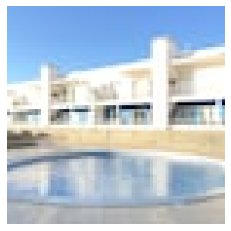

In [4]:
bathroom = './category_images/test/food_and_drink/23f4c222_t.jpg'
img_path = './category_images/test/featured_image/2fbd3261_t.jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
plt.imshow(img)
plt.axis('off')
x = tf.keras.preprocessing.image.img_to_array(img)
# tf.keras.preprocessing.image.smart_resize(x, IMAGE_SIZE)
x = tf.keras.applications.mobilenet.preprocess_input(x[tf.newaxis,...])

You'll use an image of bath room as a running example, and a Keras pre-trained image classification model since it's easy to use. Custom models work too, and are covered in detail later.

In [5]:
import json

def labels():
    with open('.\saved_models\simple_classifier\label_m.json', 'r') as filehandle:
        return json.load(filehandle)
    return None

In [6]:
class_names = labels()
print(class_names)

['bathroom', 'exterior', 'featured_image', 'living_area', 'private_kitchen', 'room']


The top prediction for this image is "bathroom".

In [7]:
loaded = tf.saved_model.load(saved_model_path)
print(list(loaded.signatures.keys()))  # ["serving_default"]

['serving_default']


Imported signatures always return dictionaries. To customize signature names and output dictionary keys, see [Specifying signatures during export](#specifying_signatures_during_export).

In [8]:
infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)

{'dense': TensorSpec(shape=(None, 6), dtype=tf.float32, name='dense')}


Running inference from the SavedModel gives the same result as the original model.

In [9]:
# labeling = infer(tf.constant(x))[pretrained_model.output_names[0]]
predictions_infer = infer(tf.constant(x))

In [10]:
predictions = predictions_infer[list(infer.structured_outputs.keys())[0]]

In [11]:
# Debug for details
# for idx, x in np.ndenumerate(scores.numpy()):
#     print(idx[0], class_names[idx[0]],  100*score)

In [12]:
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to exterior with a 24.53 percent confidence.


## Loading with keras models

This seems to give a better results; need to understand more of the difference between the first method and this second one

In [18]:
# img_height = 96
# img_width = 96
# featured './category_images/test/featured_image/2fbd3261_t.jpg' 0a6d828d_t.jpg
# interior_entrance fe4bb180_t 6ac7cc8f_t.jpg fbf46908_t
# bathroom './category_images/test/bathroom/000f3807_t.jpg'
# food and drink 0cb1ccbf_t 8a640b78_t 23f4c222_t

featured = './category_images/test/featured_image/2fbd3261_t.jpg'
bathroom = './category_images/test/bathroom/000f3807_t.jpg'
interior_entrance = './category_images/test/interior_entrance/fbf46908_t.jpg'
food_and_drink = './category_images/test/food_and_drink/23f4c222_t.jpg'
test_image_path = featured

img = keras.preprocessing.image.load_img(
    test_image_path, target_size=IMAGE_SIZE
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

In [14]:
model = tf.keras.models.load_model(saved_model_path)

In [19]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to featured_image with a 84.38 percent confidence.
